In [28]:
import math
import logging
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import numpy as np
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader
import random
from torch.utils.data import Dataset
import pandas as pd
import os
from torch.utils.tensorboard import SummaryWriter

In [29]:
device = 'cpu'
if torch.cuda.is_available():
    device = torch.cuda.current_device()

In [30]:
device

0

In [32]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:] # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)

    return x

In [33]:
logger = logging.getLogger(__name__)

In [34]:
class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k,v in kwargs.items():
            setattr(self, k, v)

class GPT1Config(GPTConfig):
    """ GPT-1 like network roughly 125M params """
    n_layer = 12
    n_head = 12
    n_embd = 768

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.block_size = block_size

    def forward(self, x, layer_past=None):
        B, T, C = x.size()
        
        self.mask = torch.tril(torch.ones(self.block_size, self.block_size))\
                                     .view(1, 1, self.block_size, self.block_size).to(device)
        if np.random.rand() < 0.1:
            rand_int = np.random.randint(10,30)
            
            add = torch.tensor(np.random.choice([0,1], size = [rand_int,rand_int], 
                                                p = [0.8, 0.2]), 
                                                dtype = torch.float).to(device)
            d_u = torch.diag(torch.ones(rand_int - 1).to(device), 1).to(device)
            add -= d_u
            
            self.mask[0,0, :rand_int, :rand_int] += add
            self.mask = torch.clamp(self.mask, min=0., max=1.)
        
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [35]:
pred_coord_g = None
y_coord_g = None
logits_tok_g = None
y_tok_g = None

writer = SummaryWriter()

In [36]:
class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, config):
        super().__init__()

        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, int(config.n_embd // 4))
        self.coord_emb = nn.Linear(4, int(config.n_embd // 4 * 3))
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head_tok = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.head_coord = nn.Linear(config.n_embd, 4)

        self.block_size = config.block_size
        self.apply(self._init_weights)
        
        self.n_iter = 0

        logger.info("number of parameters: %e", sum(p.numel() for p in self.parameters()))

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name

                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # special case the position embedding parameter in the root GPT module as not decayed
        no_decay.add('pos_emb')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both \
                                        decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were \
                                                    not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": 
             train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, x, y=None):
        
        self.n_iter += 1
        
        X_tok, X_coord = x # [bs, seq_len, 1] , [bs, seq_len, 4]
        X_coord[:,0] = torch.rand(X_coord.shape[0],4)
        if y is not None:
            y_tok, y_coord = y # [bs, seq_len, 1] , [bs, seq_len, 4]
        
        b, t, _ = X_tok.size()
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."

        # forward the GPT model
        token_embeddings = self.tok_emb(X_tok[:,:,0]) # [bs, seq_len, emb // 2 ]
        coord_embeddings = self.coord_emb(X_coord) # [bs, seq_len, emb // 2 ]
        entity_embeddings = torch.cat([token_embeddings, coord_embeddings], dim = 2) # [bs, seq_len, emb]
        position_embeddings = self.pos_emb[:, :t, :] # each position maps to a (learnable) vector
        x = self.drop(entity_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits_tok = self.head_tok(x)
        pred_coord = self.head_coord(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if y is not None:
            global pred_coord_g, y_coord_g, logits_tok_g, y_tok_g
            
            pred_coord_g, y_coord_g, logits_tok_g, y_tok_g = pred_coord, y_coord, logits_tok, y_tok
            
            loss_1 = F.cross_entropy(logits_tok.view(-1, logits_tok.size(-1)), y_tok.view(-1), 
                                     reduction="sum")
            loss_1 = loss_1 / b
            loss_2 = F.mse_loss(pred_coord, y_coord, reduction="sum")
            loss_2 = loss_2 / b
#             loss_3 = (((pred_coord_g[:,:,2] - pred_coord_g[:,:,0]) * 
#                        (pred_coord_g[:,:,3] - pred_coord_g[:,:,1]))).abs().sum() 
#             print(loss_1, loss_2, loss_3)
            loss = loss_1 + loss_2 #+ loss_3
            writer.add_scalar('Loss/cross_entropy', loss_1.item(), self.n_iter)
            writer.add_scalar('Loss/l2_loss', loss_2.item(), self.n_iter)
            #writer.add_scalar('Loss/parallel_loss', loss_3.item(), self.n_iter)
            writer.add_scalar('Loss/general_loss', loss.item(), self.n_iter)

        return (logits_tok, pred_coord) , loss

In [37]:
class TrainerConfig:
    # optimization parameters
    max_epochs = 10
    batch_size = 7
    learning_rate = 3e-4
    betas = (0.9, 0.95)
    grad_norm_clip = 1.0
    weight_decay = 0.1 # only applied on matmul weights
    # learning rate decay params: linear warmup followed by cosine decay to 10% of original
    lr_decay = False
    warmup_tokens = 375e6 # these two numbers come from the GPT-3 paper, but may not be good defaults elsewhere
    final_tokens = 260e9 # (at what point we reach 10% of original LR)
    # checkpoint settings
    ckpt_path = None
    num_workers = 0 # for DataLoader

    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)

class Trainer:

    def __init__(self, model, train_dataset, test_dataset, config):
        self.model = model
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.config = config
        self.n_iter = 0

        # take over whatever gpus are on the system
        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = torch.nn.DataParallel(self.model).to(self.device)

    def save_checkpoint(self):
        # DataParallel wrappers keep raw model object in .module attribute
        raw_model = self.model.module if hasattr(self.model, "module") else self.model
        logger.info("saving %s", self.config.ckpt_path)
        torch.save(raw_model.state_dict(), self.config.ckpt_path)

    def train(self):
        model, config = self.model, self.config
        raw_model = model.module if hasattr(self.model, "module") else model
        optimizer = raw_model.configure_optimizers(config)

        def run_epoch(split):
            is_train = split == 'train'
            model.train(is_train)
            data = self.train_dataset if is_train else self.test_dataset
            loader = DataLoader(data, shuffle=True, pin_memory=True,
                                batch_size=config.batch_size,
                                num_workers=config.num_workers,
                                drop_last = True, collate_fn=PadSequence())

            losses = []
            pbar = tqdm(enumerate(loader), total=len(loader)) if is_train else enumerate(loader)
            for it, ((X_tok, X_coord), (y_tok, y_coord)) in pbar:
                self.n_iter += 1
                # place data on the correct device
                X_tok = X_tok.to(self.device)
                X_coord = X_coord.to(self.device)
                y_tok = y_tok.to(self.device)
                y_coord = y_coord.to(self.device)
                

                # forward the model
                with torch.set_grad_enabled(is_train):
                    logits, loss = model((X_tok, X_coord), (y_tok, y_coord))
                    loss = loss.mean() # collapse all losses if they are scattered on multiple gpus
                    losses.append(loss.item())

                if is_train:

                    # backprop and update the parameters
                    model.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                    optimizer.step()

                    # decay the learning rate based on our progress
                    if config.lr_decay:
                        self.tokens += (y_tok >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
#                         print(self.tokens)
                        if self.tokens < config.warmup_tokens:
                            # linear warmup
                            lr_mult = float(self.tokens) / float(max(1, config.warmup_tokens))
                        else:
                            # cosine learning rate decay
                            progress = float(self.tokens - config.warmup_tokens) / float(max(1, config.final_tokens - config.warmup_tokens))
                            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
                        lr = config.learning_rate * lr_mult
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr
                    else:
                        lr = config.learning_rate

                    # report progress
                    pbar.set_description(f"epoch {epoch+1} iter {it}: train loss {loss.item():.5f}. lr {lr:e}")
                    
                    writer.add_scalar('LR/lr', lr, self.n_iter)
#                 break
                    
            if not is_train:
                test_loss = float(np.mean(losses))
                logger.info("test loss: %f", test_loss)
                return test_loss

        best_loss = float('inf')
        self.tokens = 0 # counter used for learning rate decay
        for epoch in range(config.max_epochs):

            run_epoch('train')
            if self.test_dataset is not None:
                test_loss = run_epoch('test')

            # supports early stopping based on the test loss, or just save always if no test set is provided
            good_model = self.test_dataset is None or test_loss < best_loss
            if self.config.ckpt_path is not None and good_model:
                best_loss = test_loss
                self.save_checkpoint()

In [38]:
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)
set_seed(42)

In [39]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, max_index):
        self.words = pd.read_csv("data_interior_3_train/vocab.csv", index_col=0)["0"].values.tolist()
        self.vocab = ["<sos>", "<eos>", "<pad>", "<unk>"] + self.words
        self.vocab_size = len(self.vocab)
        self.index_to_word = {index: word for index, word in enumerate(self.vocab)}
        self.word_to_index = {word: index for index, word in enumerate(self.vocab)}
        self.block_size = 127
        self.max_index = max_index
        
    def __len__(self):
        l = [int(x[len("entities_"):][:-len(".csv")]) for x in 
                list(filter(None, 
                filter(lambda x: ".csv" in x and x != 'vocab.csv', 
                       os.listdir("./data_interior_3_train"))))]
        return self.max_index
    
    def __getitem__(self, index):
        
        lst_tokens = pd.read_csv(
                "data_interior_3_train/entities_{}.csv".format(index), 
                index_col=0).category.values.tolist()[:self.block_size-2]

        coord_tensor = torch.tensor(
            np.load("data_interior_3_train/coordinates_{}.npy".format(index)), 
            dtype = torch.float).t()[:self.block_size-2,:]

        sentence = ["<sos>"] + lst_tokens + ["<eos>"] #+ ["<pad>"] * (self.block_size - len(lst_tokens) - 2)
        sentence_indices = [self.word_to_index[w] for w in sentence]

        tokens_tenor = torch.tensor(sentence_indices)
        
        coord_padded = torch.cat([
            torch.zeros([1,4]),
            coord_tensor,
            #torch.zeros([self.block_size - coord_tensor.shape[0] - 1, 4])
            torch.zeros([1,4]),
        ])
        
        return ((tokens_tenor.unsqueeze(0).t()[:-1], coord_padded[:-1]),
                (tokens_tenor.unsqueeze(0).t()[1:], coord_padded[1:]))

In [40]:
l = [int(x[len("entities_"):][:-len(".csv")]) for x in 
        list(filter(None, 
        filter(lambda x: ".csv" in x and x != 'vocab.csv', 
               os.listdir("./data_interior_3_train"))))]
max_index = max(l)
train_dataset = Dataset(max_index)

In [41]:
class PadSequence:
    def __call__(self, batch):
        len_batch = len(batch)
        max_len = max([batch[i][0][0].shape[0] for i in range(len_batch)])
#         max_len = max(max_len, 30)
        X_tok_batch = torch.zeros([1, max_len, 1], dtype = torch.int)#.to(device) 
        X_coord_batch = torch.zeros([1, max_len, 4])#.to(device) 
        y_tok_batch = torch.zeros([1, max_len, 1], dtype = torch.int)#.to(device)
        y_coord_batch = torch.zeros([1, max_len, 4])#.to(device) 
        for i in range(len_batch):
            (X_tok, X_coord), (y_tok, y_coord) = batch[i]
            X_tok = X_tok#.to(device)
            X_coord = X_coord#.to(device)
            y_tok = y_tok#.to(device)
            y_coord = y_coord#.to(device)
            cur_len = X_tok.shape[0]
            X_tok = torch.cat([
                            X_tok, 
                            torch.ones([max_len - cur_len, 1], dtype = torch.int) * \
                                train_dataset.word_to_index["<pad>"]
                            ], dim = 0)
            X_coord = torch.cat([X_coord, torch.zeros([max_len - cur_len, 4])], dim = 0)
            y_tok = torch.cat([
                            y_tok, 
                            torch.ones([max_len - cur_len, 1], dtype = torch.int) * \
                                train_dataset.word_to_index["<pad>"]
                            ], dim = 0)
            y_coord = torch.cat([y_coord, torch.zeros([max_len - cur_len, 4])], dim = 0)
            batch[i] = (X_tok, X_coord), (y_tok, y_coord)

            X_tok_batch = torch.cat([X_tok_batch, X_tok.unsqueeze(0)], dim = 0)
            X_coord_batch = torch.cat([X_coord_batch, X_coord.unsqueeze(0)], dim = 0)
            y_tok_batch = torch.cat([y_tok_batch, y_tok.unsqueeze(0)], dim = 0)
            y_coord_batch = torch.cat([y_coord_batch, y_coord.unsqueeze(0)], dim = 0)
            
        X_tok_batch = X_tok_batch[1:,:,:]
        X_coord_batch = X_coord_batch[1:,:,:]
        y_tok_batch = y_tok_batch[1:,:,:]
        y_coord_batch = y_coord_batch[1:,:,:]
        
        return (X_tok_batch, X_coord_batch), (y_tok_batch, y_coord_batch)

In [42]:
block_size = 127

In [44]:
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=3, n_head=4, n_embd=384)
model = GPT(mconf)

06/08/2021 01:06:28 - INFO - __main__ -   number of parameters: 5.397028e+06


In [45]:
tconf = TrainerConfig(max_epochs=700, batch_size=700, learning_rate=5e-4,
                      lr_decay=True, warmup_tokens=block_size*len(train_dataset)*32, 
                      final_tokens=2*len(train_dataset)*block_size,
                      num_workers=0)
trainer = Trainer(model, train_dataset, None, tconf)

In [46]:
# # torch.save(model.state_dict(), "./interior_gpt_model_v2.pt")
# model.load_state_dict(torch.load("./interior_gpt_model_v2_5_floyd_1st_full.pt", 
#                                  map_location=torch.device('cpu')))

In [ ]:
trainer.train()

In [48]:
torch.save(model.state_dict(), "./interior_gpt_model_v3_all_categories_v1.pt")
# model.load_state_dict(torch.load("./interior_gpt_model_v2.pt"))

In [49]:
train_dataset.__len__()

79187

In [212]:
(X_tok, X_coord), (y_tok, y_coord) = train_dataset.__getitem__(777)

In [213]:
index_door = (X_tok == train_dataset.word_to_index["door"]).nonzero(as_tuple=True)[0][0]
X_acc_tok = X_tok[:index_door,:].unsqueeze(0).to(device)
X_acc_coord = X_coord[:index_door,:].unsqueeze(0).to(device)

In [214]:
# X_acc_tok = torch.tensor([train_dataset.word_to_index["<sos>"]], 
#                       dtype=torch.long).view(1,1,-1).transpose(1,2).to(trainer.device)
# X_acc_coord = torch.rand([1,1,4]).to(trainer.device)

model.eval()
# model.train()
pass

In [215]:
X_acc_tok.shape, X_acc_coord.shape

(torch.Size([1, 31, 1]), torch.Size([1, 31, 4]))

In [216]:
for i in range(index_door.item()-1, 125):
    y_pred_tok_logits, y_pred_coord = model((X_acc_tok, X_acc_coord))[0]
    X_acc_tok = torch.cat([X_acc_tok, y_pred_tok_logits[0][-1].argmax().view([1,1,1])], dim = 1)
    X_acc_coord = torch.cat([X_acc_coord, y_pred_coord[0][-1].view(1,1,4)], dim = 1)

In [217]:
def denorm(l):
#     print(l)
    x_min, y_min, x_max, y_max = l
    x_mean, x_std, y_mean, y_std = np.load('data_interior_1/mean_std.npy')
    
    x_min_real = x_min * x_std + x_mean
    x_max_real = x_max * x_std + x_mean
    y_min_real = y_min * y_std + y_mean
    y_max_real = y_max * y_std + y_mean
    
    return x_min_real, y_min_real, x_max_real, y_max_real

In [218]:
try:
    eos_idx = X_acc_tok.view(101).tolist().index(train_dataset.word_to_index["<eos>"])
except:
    eos_idx = 101

In [219]:
eos_idx = X_acc_tok.view(-1).tolist().index(train_dataset.word_to_index["<eos>"])

In [220]:
eos_idx

66

In [221]:
X_acc_coord.shape

torch.Size([1, 126, 4])

In [222]:
tokens_idx = X_acc_tok.view(-1).tolist()[1:eos_idx]
tokens = [train_dataset.index_to_word[x] for x in tokens_idx]

In [223]:
array_coord = X_acc_coord.view(X_acc_coord.shape[1],4)[1:eos_idx,:].detach().cpu().numpy()
coords = [denorm(x) for x in array_coord]

In [224]:
df = pd.DataFrame(columns=["x_min", "y_min", "x_max", "y_max", "category"])
df.category = tokens
df[["x_min", "y_min", "x_max", "y_max"]] = coords

In [225]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [226]:
colors_dict = {
 'door' : "blue",
 'washing_basin' : "orange",
 'cooking_counter' : "brown",
 'special' : "gold",
 'bathtub' : "tab:red",
 'entrance' : "tab:orange",
 'toilet' : "lime",
 'bedroom' : "darkviolet",
 'corridor' : "rosybrown",
 'restroom' : "tan",
 'closet' : "springgreen",
 'kitchen' : "olive",
 'washing_room' : "teal",
 'bathroom' : "hotpink",
 'living_room' : "pink",
 'balcony' : "peru",
 'wall' : "red",
 'PS' : "green",
 'stairs' : "violet",
 'point' : "cyan"
}

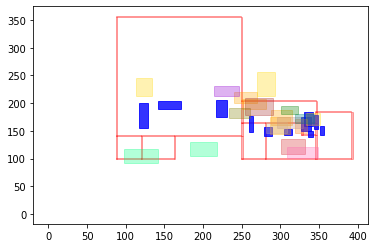

In [227]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# d = normalized_train_df[normalized_train_df.id == 13]

fig, ax = plt.subplots()

#create simple line plot
c = 0
ax.plot([c, c],[c, c])

for idx, (x_min, y_min, x_max, y_max, category) in df.iterrows():
    
    w = x_max - x_min
    w = 2 if w == 0 else w
    h = y_max - y_min
    h = 2 if h == 0 else h

    if category == "point":
        w = 12
        h = 12
        ax.add_patch(Rectangle((x_min, y_min), w, h, color = colors_dict[category], alpha = 0.2))
    elif category == "door":
        ax.add_patch(Rectangle((x_min, y_min), w, h, color = colors_dict[category], alpha = 0.8))
    else:
        try:
            ax.add_patch(Rectangle((x_min, y_min), w, h, color = colors_dict[category], alpha = 0.3))
        except:
            pass

#     break
#display plot
plt.show()

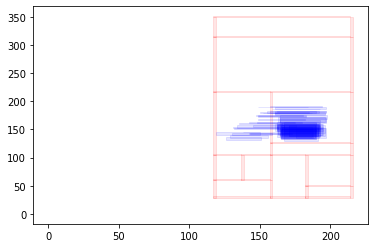

In [120]:
fig, ax = plt.subplots()

#create simple line plot
c = 0
ax.plot([c, c],[c, c])

for idx, (x_min, y_min, x_max, y_max, category) in df.iterrows():
#     print(x_max, y_max)
    x_min = int(x_min)
    y_min = int(y_min)
    x_max = int(x_max)
    y_max = int(y_max)
#     if category not in ["wall"]: continue
    
    w = x_max - x_min
    w = 2 if w == 0 else w
    h = y_max - y_min
    h = 2 if h == 0 else h
    if category == "wall":
        ax.add_patch(Rectangle((x_min, y_min), w, h, color = "red", alpha = 0.1))
    elif category == "door":
        ax.add_patch(Rectangle((x_min, y_min), w, h, color = "blue", alpha = 0.1))

#     break
#display plot
plt.show()

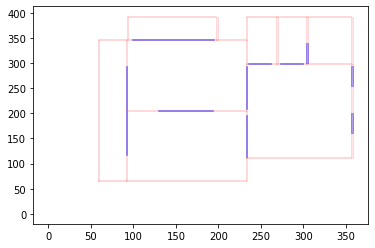

In [179]:
# eos_idx = X_tok.view(-1).tolist().index(train_dataset.word_to_index["<eos>"])
tokens_idx = X_tok.view(-1).tolist()[1:eos_idx]
tokens = [train_dataset.index_to_word[x] for x in tokens_idx]

array_coord = X_coord.view(X_coord.shape[0],4)[1:,:].detach().numpy()
coords = [denorm(x) for x in array_coord]

df = pd.DataFrame(columns=["x_min", "y_min", "x_max", "y_max", "category"])
df.category = tokens
df[["x_min", "y_min", "x_max", "y_max"]] = coords[:len(tokens)]

fig, ax = plt.subplots()

#create simple line plot
c = 0
ax.plot([c, c],[c, c])

for idx, (x_min, y_min, x_max, y_max, category) in df.iterrows():
#     print(x_max, y_max)
    x_min = int(x_min)
    y_min = int(y_min)
    x_max = int(x_max)
    y_max = int(y_max)
#     if category not in ["wall"]: continue
    
    w = x_max - x_min
    w = 2 if w == 0 else w
    h = y_max - y_min
    h = 2 if h == 0 else h
    if category == "wall":
        ax.add_patch(Rectangle((x_min, y_min), w, h, color = "red", alpha = 0.1))
    elif category == "door":
        ax.add_patch(Rectangle((x_min, y_min), w, h, color = "blue", alpha = 0.3))

#     break
#display plot
plt.show()

In [137]:
len(train_dataset)

1277

In [203]:
100_000 / 8

12500.0

In [206]:
warmup_tokens = [512 * 2000] #200*len(train_dataset)*8, 
final_tokens = [60*len(train_dataset)*block_size] #2*len(train_dataset)*block_size,
learning_rate = 6e-5
lst = []
tokens = 0

warmup_tokens = warmup_tokens[0]
final_tokens = final_tokens[0]
# print(final_tokens)
for i in range(0, 100_000):
#     print(1, end= "")
    if True:
        tokens += 100#(y_tok >= 0).sum() # number of tokens processed this step (i.e. label is not -100)
    #                         print(self.tokens)
#         print(warmup_tokens)
        if tokens < warmup_tokens:
            # linear warmup
            lr_mult = float(tokens) / float(max(1, warmup_tokens))
        else:
            # cosine learning rate decay
            progress = float(tokens - warmup_tokens) / float(max(1, final_tokens - warmup_tokens))
            lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * progress)))
        lr = learning_rate * lr_mult
    else:
        lr = learning_rate
    lst.append(lr)

<AxesSubplot:>

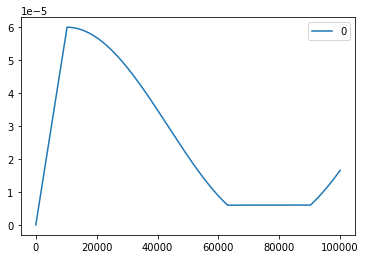

In [207]:
pd.DataFrame(lst).plot()

In [135]:
block_size*len(train_dataset)*8

1021600

In [136]:
warmup_tokens

(1021600,)

In [239]:
y_pred_tok_logits, y_pred_coord = model((X_acc_tok, X_acc_coord))[0]

In [241]:
y_pred_tok_logits[0][-1].argmax().view([1,1,1])

tensor([[[5]]])

In [244]:
X_acc_tok = torch.cat([X_acc_tok, y_pred_tok_logits[0][-1].argmax().view([1,1,1])], dim = 1)

In [245]:
X_acc_tok

tensor([[[0],
         [5]]])

In [246]:
X_acc_coord = torch.cat([X_acc_coord, y_pred_coord[0][-1].view(1,1,4)], dim = 1)

In [247]:
X_acc_coord

tensor([[[0.8743, 0.5398, 0.7056, 0.2340],
         [0.1647, 0.2532, 0.1402, 0.2543]]], grad_fn=<CatBackward>)

In [87]:
pred_coord_g, y_coord_g, logits_tok_g, y_tok_g

(tensor([[[-2.3111e-01, -3.0194e-01, -2.4044e-01,  1.0043e-02],
          [-2.1674e-01, -3.5572e-01,  5.0945e-02, -9.0140e-02],
          [-1.7926e-01, -2.8573e-01, -7.2330e-02, -1.2373e-01],
          ...,
          [-8.4137e-02, -1.1956e-02,  3.0616e-01,  1.7163e-01],
          [-1.4407e-01, -5.7687e-04,  2.2275e-01,  1.8957e-01],
          [-7.8394e-02,  6.2236e-02,  2.6401e-01,  1.5516e-01]],
 
         [[-5.0310e-02, -3.7494e-01, -5.7372e-02,  2.3746e-03],
          [-1.6248e-01, -4.8149e-01,  3.8270e-02, -4.9086e-02],
          [ 8.7308e-02, -3.2867e-01, -8.9528e-02, -2.4724e-02],
          ...,
          [-7.2178e-02, -5.3699e-02,  2.3211e-01,  2.2761e-01],
          [-1.3351e-01,  1.2589e-01,  1.5876e-01,  1.5753e-01],
          [-1.8494e-01,  5.6812e-04,  1.1613e-01,  2.3742e-01]],
 
         [[-2.2756e-01, -4.6461e-01, -1.7225e-01, -1.4562e-02],
          [-1.9756e-01, -3.5476e-01, -2.1051e-01, -7.5366e-03],
          [-3.3056e-01, -3.8877e-01, -2.7589e-01, -3.0225e-02],
    

In [88]:
loss_1 = F.cross_entropy(logits_tok_g.view(-1, logits_tok_g.size(-1)), y_tok_g.view(-1),)
loss_2 = F.l1_loss(pred_coord_g, y_coord_g)

In [89]:
loss_1

tensor(0.1704, grad_fn=<NllLossBackward>)

In [90]:
loss_2

tensor(0.3015, grad_fn=<L1LossBackward>)

In [92]:
pred_coord_g.shape

torch.Size([5, 99, 4])

In [93]:
x_min, y_min, x_max, y_max = pred_coord_g[0][0]

In [95]:
(x_max - x_min) * (y_max - y_min)

tensor(-0.0029, grad_fn=<MulBackward0>)

In [111]:
(((pred_coord_g[:,:,2] - pred_coord_g[:,:,0]) * (pred_coord_g[:,:,3] - pred_coord_g[:,:,1]))).abs().mean()

tensor(0.0809, grad_fn=<MeanBackward0>)

In [73]:
dl = DataLoader(train_dataset, batch_size = 5)

In [74]:
for batch in dl:
    break
batch

[tensor([[18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
          53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
           1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
          57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
           6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
          58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
           1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
          53,  1]]),
 tensor([[47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44, 53,
          56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,  1,
          44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1, 57,
          54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,  6,
           1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,

In [66]:
batch[0].shape # 1, seq_len

torch.Size([1, 128])

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self):
        self.words = pd.read_csv("data_interior_1/vocab.csv", index_col=0)["0"].values.tolist()
        self.vocab = ["<sos>", "<eos>", "<pad>", "<unk>"] + self.words
        self.index_to_word = {index: word for index, word in enumerate(self.vocab)}
        self.word_to_index = {word: index for index, word in enumerate(self.vocab)}
        
        
    def __len__(self):
        l = [int(x[len("entities_"):][:-len(".csv")]) for x in 
                list(filter(None, 
                filter(lambda x: ".csv" in x and x != 'vocab.csv', 
                       os.listdir("./data_interior_1"))))]
        return max(l)
    
    def __getitem__(self, index):
        
        lst_tokens = pd.read_csv(
                "data_interior_1/entities_{}.csv".format(index), 
                index_col=0).category.values.tolist()

        coord_tensor = torch.tensor(
            np.load("data_interior_1/coordinates_{}.npy".format(index)), 
            dtype = torch.float).t()

        sentence = ["<sos>"] + lst_tokens + ["<eos>"] + ["<pad>"] * (100 - len(lst_tokens) - 2)
        sentence_indices = [self.word_to_index[w] for w in sentence]

        tokens_tenor = torch.tensor(sentence_indices)
        
        coord_padded = torch.cat([
            torch.zeros([1,4]),
            coord_tensor,
            torch.zeros([100 - coord_tensor.shape[0] - 1, 4])
        ])
        
#         final_tensor = torch.cat([tokens_tenor.unsqueeze(0), coord_padded.t()], dim = 0).t()
        
        return ((tokens_tenor.unsqueeze(0).t()[:-1], coord_padded[:-1]),
                (tokens_tenor.unsqueeze(0).t()[1:], coord_padded[1:]))

In [12]:
dataset = Dataset()
dataloader = DataLoader(
    dataset,
    batch_size=3,
)

In [67]:
for batch in dataloader:
    break
x, y = batch

In [69]:
x[0].shape

torch.Size([5, 99, 1])